***Step 1: Loading and exploring the data***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
weather_data = pd.read_csv('3986077.csv')
ridership_data = pd.read_csv('Jan19_to_Present.csv')
socioeconomic_data = pd.read_csv('social_economic_data_rideship.csv')

# Display basic information about each dataset
print("Weather data shape:", weather_data.shape)
print("Ridership data shape:", ridership_data.shape)
print("Socioeconomic data shape:", socioeconomic_data.shape)

# Display the first few rows of each dataset to understand their structure
print("\nWeather data preview:")
print(weather_data.head())

print("\nRidership data preview:")
print(ridership_data.head())

print("\nSocioeconomic data preview:")
print(socioeconomic_data.head())

Weather data shape: (2223, 15)
Ridership data shape: (28013, 7)
Socioeconomic data shape: (7, 73)

Weather data preview:
       STATION                                       NAME        DATE  PRCP  \
0  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US  2019-01-01  0.09   
1  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US  2019-01-02  0.00   
2  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US  2019-01-03  0.00   
3  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US  2019-01-04  0.04   
4  USW00013739  PHILADELPHIA INTERNATIONAL AIRPORT, PA US  2019-01-05  0.53   

   SNWD  TMAX  TMIN  WT01  WT02  WT03  WT04  WT05  WT06  WT08  WT09  
0   0.0    61    43   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   0.0    43    37   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   0.0    46    34   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3   0.0    45    31   1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4   0.0    47    40   1.0   NaN   NaN   NaN   NaN   Na

***Step 2: Data preprocessing and cleaning***

Missing values in weather data:
DATE    0
PRCP    0
TMAX    0
TMIN    0
dtype: int64

Temperature summary statistics (in Fahrenheit):
              TMAX         TMIN
count  2223.000000  2223.000000
mean     66.376518    49.330184
std      17.899332    16.475545
min      18.000000     5.000000
25%      52.000000    35.000000
50%      68.000000    49.000000
75%      82.000000    64.000000
max      99.000000    81.000000

Extreme weather thresholds:
Very hot days (90th percentile): TMAX ≥ 89.0°F
Very cold days (10th percentile): TMAX < 42.0°F
Heavy precipitation days (90th percentile, excluding zero precipitation): PRCP ≥ 0.94 inches

Number of extreme weather days:
Very hot days: 248
Very cold days: 204
Heavy precipitation days: 76


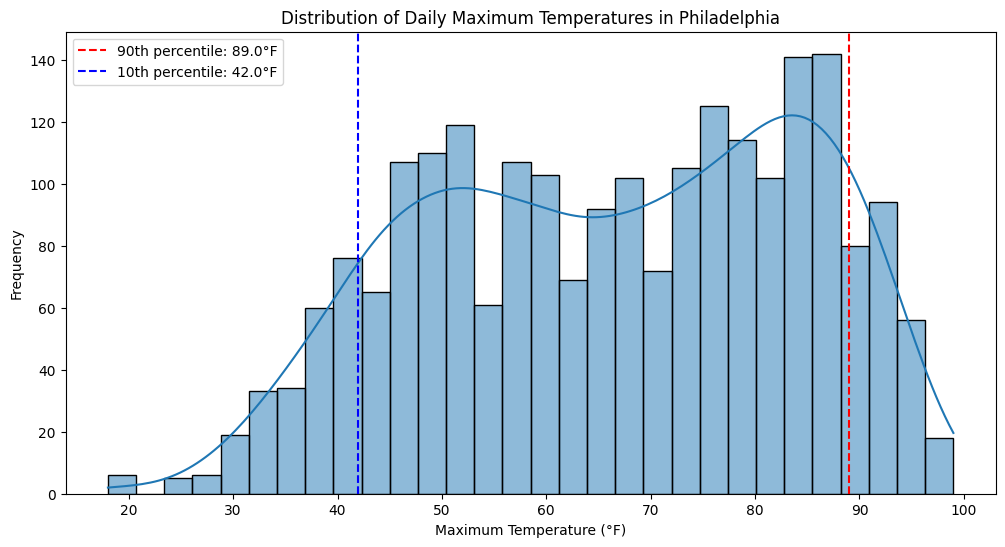

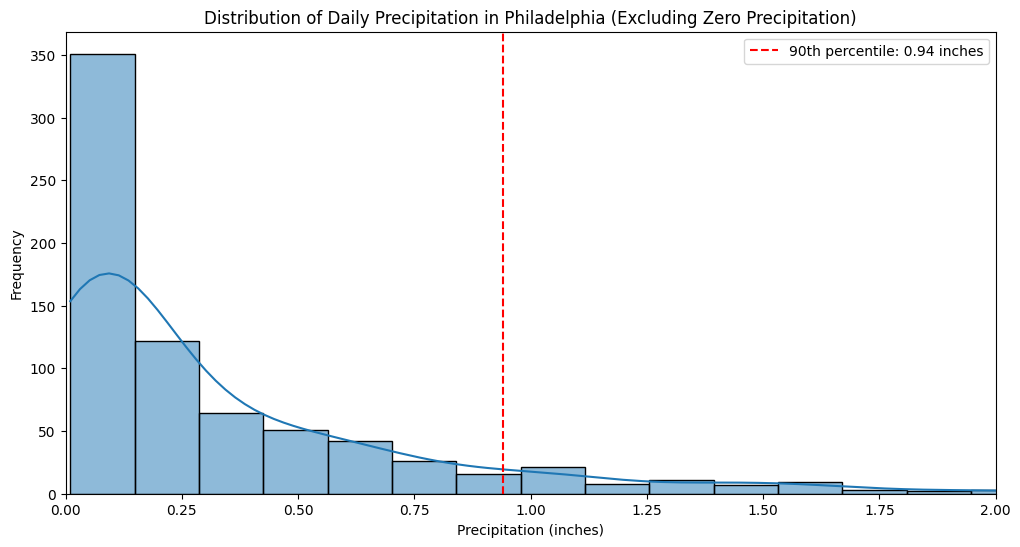

In [4]:
# Convert the date column to datetime format
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

# Check for missing values in key weather columns
print("Missing values in weather data:")
print(weather_data[['DATE', 'PRCP', 'TMAX', 'TMIN']].isnull().sum())

# Create a year-month column for later merging with ridership data
weather_data['Year'] = weather_data['DATE'].dt.year
weather_data['Month'] = weather_data['DATE'].dt.month
weather_data['Month_Name'] = weather_data['DATE'].dt.strftime('%B')

# Understand the temperature distribution to define extreme weather thresholds
print("\nTemperature summary statistics (in Fahrenheit):")
print(weather_data[['TMAX', 'TMIN']].describe())

# Define extreme weather thresholds (10th and 90th percentiles)
temp_max_90th = weather_data['TMAX'].quantile(0.9)
temp_max_10th = weather_data['TMAX'].quantile(0.1)
# Calculate 90th percentile for precipitation, excluding days with no precipitation
precip_non_zero = weather_data[weather_data['PRCP'] > 0]['PRCP']
precip_90th = precip_non_zero.quantile(0.9)

print(f"\nExtreme weather thresholds:")
print(f"Very hot days (90th percentile): TMAX ≥ {temp_max_90th:.1f}°F")
print(f"Very cold days (10th percentile): TMAX < {temp_max_10th:.1f}°F")
print(f"Heavy precipitation days (90th percentile, excluding zero precipitation): PRCP ≥ {precip_90th:.2f} inches")

# Create flags for extreme weather days
weather_data['Very_Hot_Day'] = weather_data['TMAX'] >= temp_max_90th
weather_data['Very_Cold_Day'] = weather_data['TMAX'] < temp_max_10th
weather_data['Heavy_Precip_Day'] = weather_data['PRCP'] >= precip_90th

# Count how many extreme weather days we have in our dataset
print("\nNumber of extreme weather days:")
print(f"Very hot days: {weather_data['Very_Hot_Day'].sum()}")
print(f"Very cold days: {weather_data['Very_Cold_Day'].sum()}")
print(f"Heavy precipitation days: {weather_data['Heavy_Precip_Day'].sum()}")

# Visualize extreme temperature distribution
plt.figure(figsize=(12, 6))
sns.histplot(weather_data['TMAX'], bins=30, kde=True)
plt.axvline(x=temp_max_90th, color='r', linestyle='--', label=f'90th percentile: {temp_max_90th:.1f}°F')
plt.axvline(x=temp_max_10th, color='b', linestyle='--', label=f'10th percentile: {temp_max_10th:.1f}°F')
plt.title('Distribution of Daily Maximum Temperatures in Philadelphia')
plt.xlabel('Maximum Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Visualize precipitation distribution (showing only non-zero precipitation)
plt.figure(figsize=(12, 6))
sns.histplot(precip_non_zero, bins=30, kde=True)
plt.axvline(x=precip_90th, color='r', linestyle='--', label=f'90th percentile: {precip_90th:.2f} inches')
plt.title('Distribution of Daily Precipitation in Philadelphia (Excluding Zero Precipitation)')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, max(2, precip_90th * 1.2))  # Adjust x-axis limit dynamically based on 90th percentile
plt.show()

***Step 3: Monthly aggregation and dataset merging***

In [5]:
# Aggregate weather data by year and month
monthly_weather = weather_data.groupby(['Year', 'Month', 'Month_Name']).agg(
    Very_Hot_Days=('Very_Hot_Day', 'sum'),
    Very_Cold_Days=('Very_Cold_Day', 'sum'),
    Heavy_Precip_Days=('Heavy_Precip_Day', 'sum'),
    Avg_TMAX=('TMAX', 'mean'),
    Avg_TMIN=('TMIN', 'mean'),
    Total_PRCP=('PRCP', 'sum')
).reset_index()

print("Monthly weather aggregation preview:")
print(monthly_weather.head())

# Format month name in ridership data to match weather data
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
ridership_data['Month_Num'] = ridership_data['Month'].map(month_mapping)

# Aggregate ridership data by year, month, and mode
monthly_ridership = ridership_data.groupby(['Year', 'Month_Num', 'Month', 'Mode']).agg(
    Total_Ridership=('Ridership', 'sum'),
    Route_Count=('Route', 'count')
).reset_index()

print("\nMonthly ridership aggregation preview:")
print(monthly_ridership.head())

# Merge weather and ridership data
merged_data = pd.merge(
    monthly_ridership,
    monthly_weather,
    left_on=['Year', 'Month_Num'],
    right_on=['Year', 'Month'],
    how='inner'
)

# Check the merged dataset
print("\nMerged data preview:")
print(merged_data.head())
print("\nMerged data shape:", merged_data.shape)

# Summary statistics by transit mode
mode_summary = merged_data.groupby('Mode').agg(
    Avg_Ridership=('Total_Ridership', 'mean'),
    Avg_Hot_Days=('Very_Hot_Days', 'mean'),
    Avg_Cold_Days=('Very_Cold_Days', 'mean'),
    Avg_Precip_Days=('Heavy_Precip_Days', 'mean')
).reset_index()

print("\nSummary by transit mode:")
print(mode_summary)

# Correlation analysis
print("\nCorrelation between weather and ridership:")
correlation = merged_data[['Total_Ridership', 'Very_Hot_Days', 'Very_Cold_Days',
                          'Heavy_Precip_Days', 'Avg_TMAX', 'Avg_TMIN', 'Total_PRCP']].corr()
print(correlation['Total_Ridership'].sort_values(ascending=False))

Monthly weather aggregation preview:
   Year  Month Month_Name  Very_Hot_Days  Very_Cold_Days  Heavy_Precip_Days  \
0  2019      1    January              0              18                  1   
1  2019      2   February              0              11                  1   
2  2019      3      March              0               7                  0   
3  2019      4      April              0               0                  0   
4  2019      5        May              2               0                  2   

    Avg_TMAX   Avg_TMIN  Total_PRCP  
0  40.516129  26.161290        3.92  
1  44.392857  29.750000        3.27  
2  51.193548  34.354839        3.85  
3  68.733333  49.266667        3.02  
4  75.129032  57.709677        5.22  

Monthly ridership aggregation preview:
   Year  Month_Num    Month               Mode  Total_Ridership  Route_Count
0  2019          1  January                Bus         858917.0          331
1  2019          1  January                CCT           4294.0   

***Step 4: Visualizing relationships between weather and ridership***


Percentiles for Distributions:
TMAX 90th Percentile: 89.0°F
TMAX 10th Percentile: 42.0°F
PRCP 90th Percentile (non-zero days): 0.94 inches


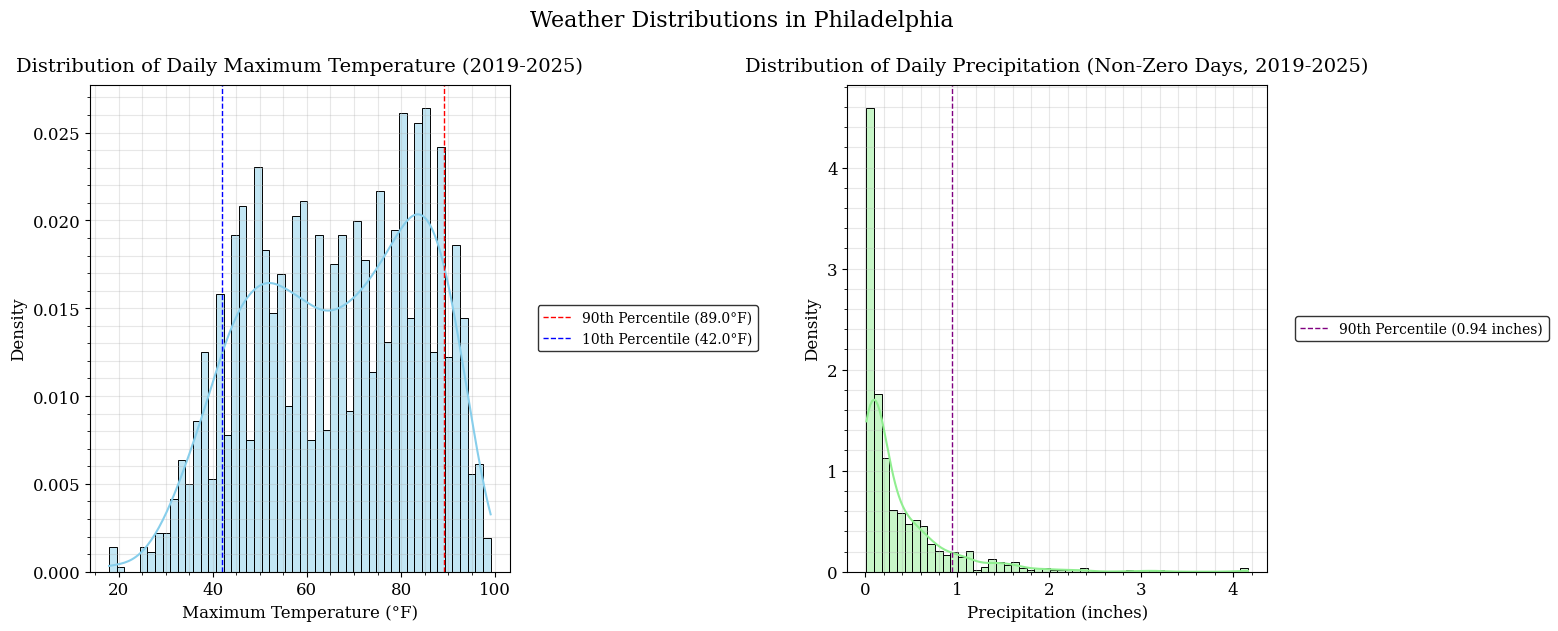

In [6]:
# Import necessary libraries (already included in previous code)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set academic style (already set in previous code, repeated here for clarity)
#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

# Assuming weather_data is already loaded and processed from the previous code
# If not, you can load it as follows:
# weather_data = pd.read_csv('3986077.csv')
# weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

# Step 1: Calculate the percentiles for TMAX and PRCP
# 90th and 10th percentiles for TMAX
tmax_90th = np.percentile(weather_data['TMAX'], 90)
tmax_10th = np.percentile(weather_data['TMAX'], 10)

# 90th percentile for PRCP (non-zero precipitation days only)
prcp_non_zero = weather_data[weather_data['PRCP'] > 0]['PRCP']
prcp_90th = np.percentile(prcp_non_zero, 90)

# Print the percentiles for reference
print("\nPercentiles for Distributions:")
print(f"TMAX 90th Percentile: {tmax_90th:.1f}°F")
print(f"TMAX 10th Percentile: {tmax_10th:.1f}°F")
print(f"PRCP 90th Percentile (non-zero days): {prcp_90th:.2f} inches")

# Step 2: Plot the distributions
fig = plt.figure(figsize=(15, 6))

# Plot 1: Distribution of Daily Maximum Temperature (TMAX)
ax1 = plt.subplot(1, 2, 1)
sns.histplot(weather_data['TMAX'], bins=50, kde=True, color='skyblue', stat='density', ax=ax1)
plt.axvline(tmax_90th, color='red', linestyle='--', linewidth=1, label=f'90th Percentile ({tmax_90th:.1f}°F)')
plt.axvline(tmax_10th, color='blue', linestyle='--', linewidth=1, label=f'10th Percentile ({tmax_10th:.1f}°F)')
plt.title('Distribution of Daily Maximum Temperature (2019-2025)', fontsize=14, pad=10)
plt.xlabel('Maximum Temperature (°F)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10, frameon=True, edgecolor='black')
plt.grid(True, which='both', alpha=0.3)
plt.minorticks_on()

# Plot 2: Distribution of Daily Precipitation (PRCP, non-zero days)
ax2 = plt.subplot(1, 2, 2)
sns.histplot(prcp_non_zero, bins=50, kde=True, color='lightgreen', stat='density', ax=ax2)
plt.axvline(prcp_90th, color='purple', linestyle='--', linewidth=1, label=f'90th Percentile ({prcp_90th:.2f} inches)')
plt.title('Distribution of Daily Precipitation (Non-Zero Days, 2019-2025)', fontsize=14, pad=10)
plt.xlabel('Precipitation (inches)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10, frameon=True, edgecolor='black')
plt.grid(True, which='both', alpha=0.3)
plt.minorticks_on()

# Adjust layout to accommodate legends
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.suptitle('Weather Distributions in Philadelphia', y=1.05, fontsize=16)
plt.show()

***Step 5:Mounth stastical data***

Weather data shape: (2223, 15)
Ridership data shape: (28013, 7)
Socioeconomic data shape: (7, 73)

Missing values in weather data:
DATE    0
PRCP    0
TMAX    0
TMIN    0
dtype: int64

Extreme Weather Thresholds (Entire Dataset):
Hot > 89.0°F
Cold < 42.0°F
Heavy Precipitation: > 0.94 inches

Extreme Weather Event Counts:
Very Hot Days: 248
Very Cold Days: 239
Heavy Precipitation Days: 76
Consecutive Hot Days: 158
Consecutive Cold Days: 145
Consecutive Precipitation Days: 3
Heat Wave Days (3+ consecutive): 102
Cold Wave Days (3+ consecutive): 97


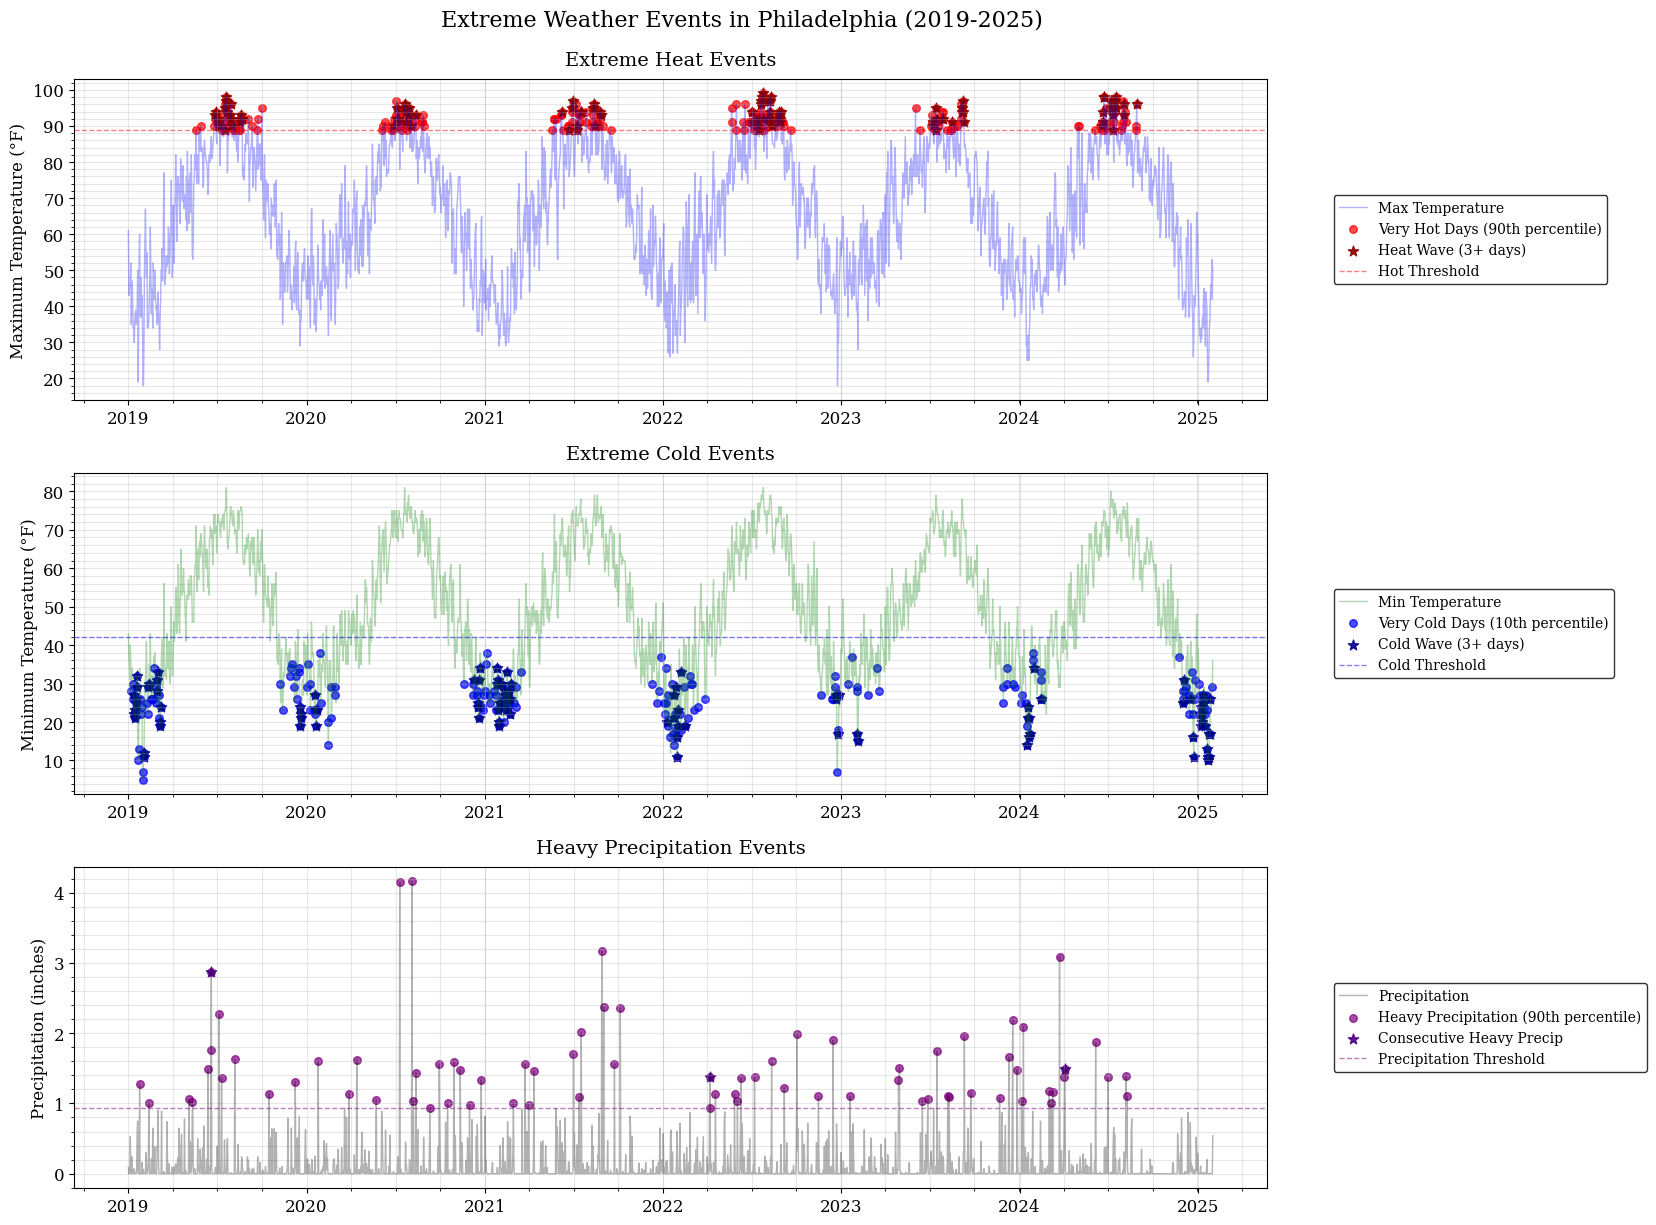

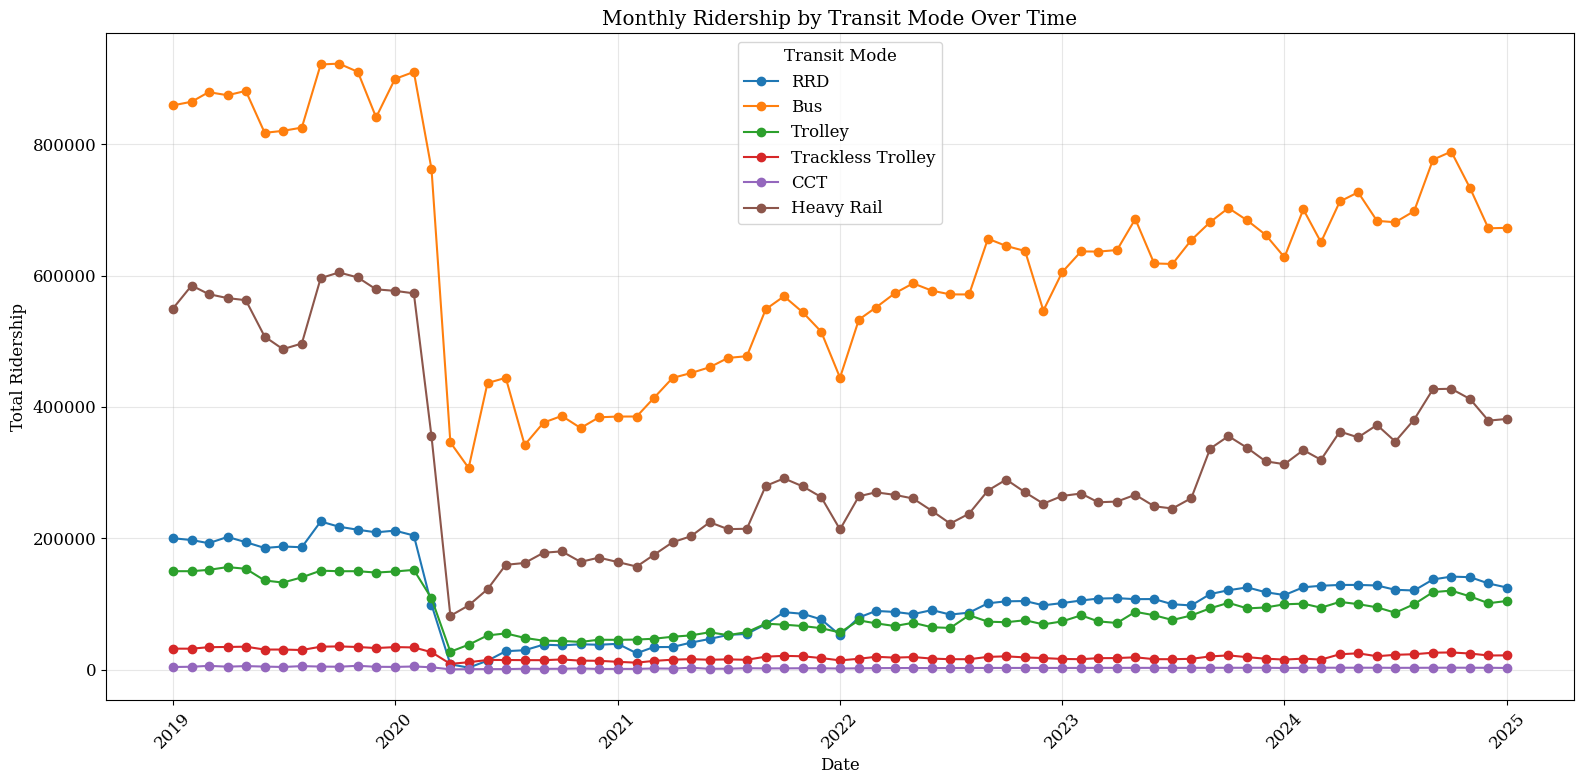

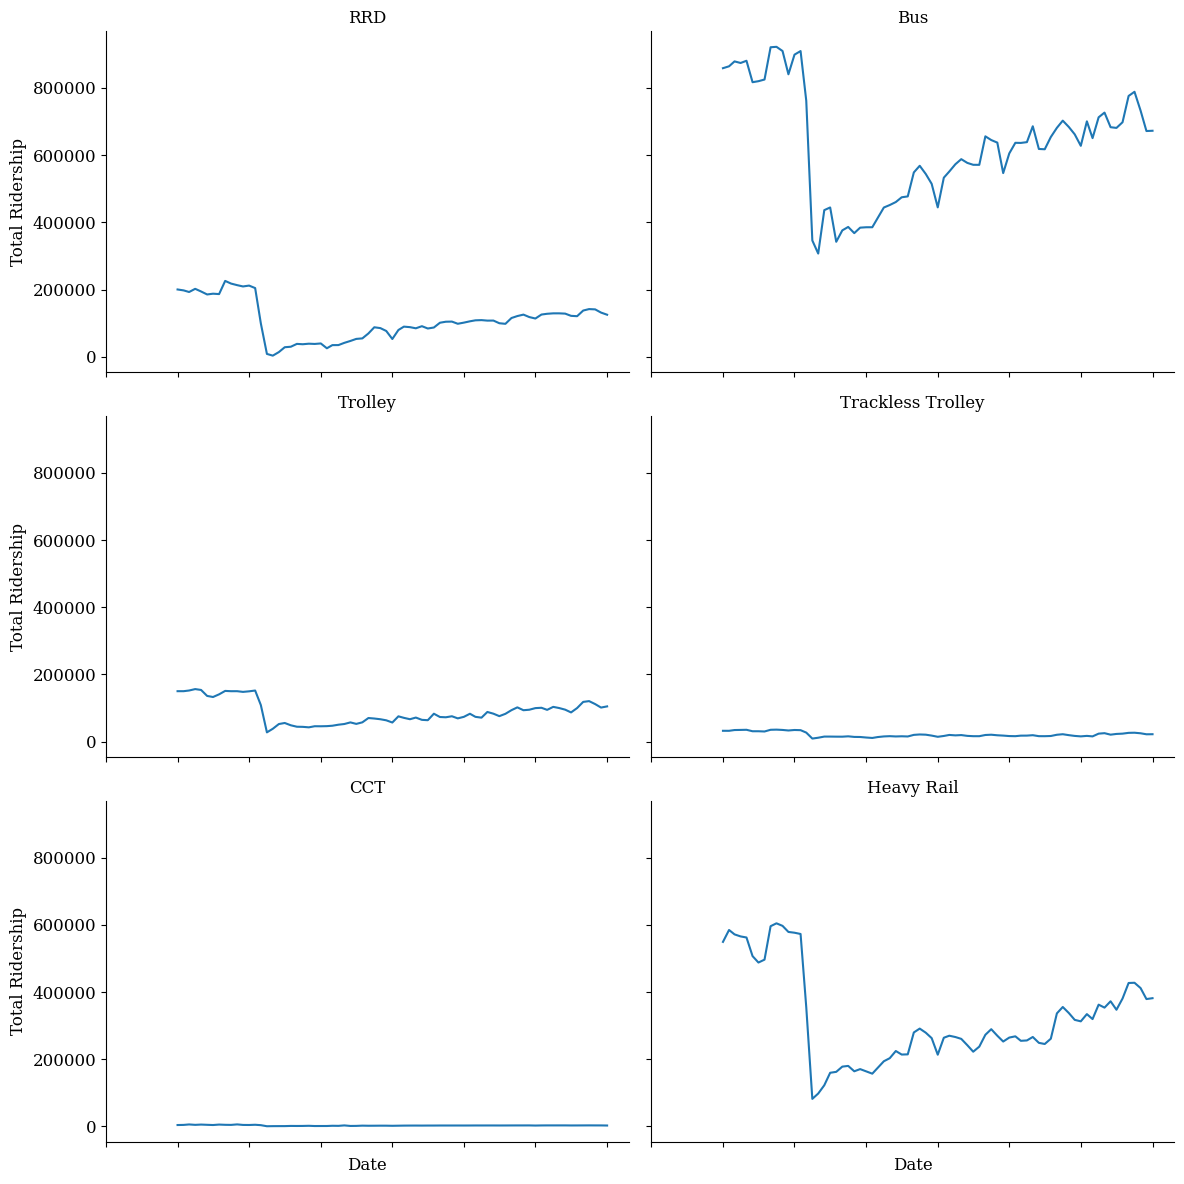

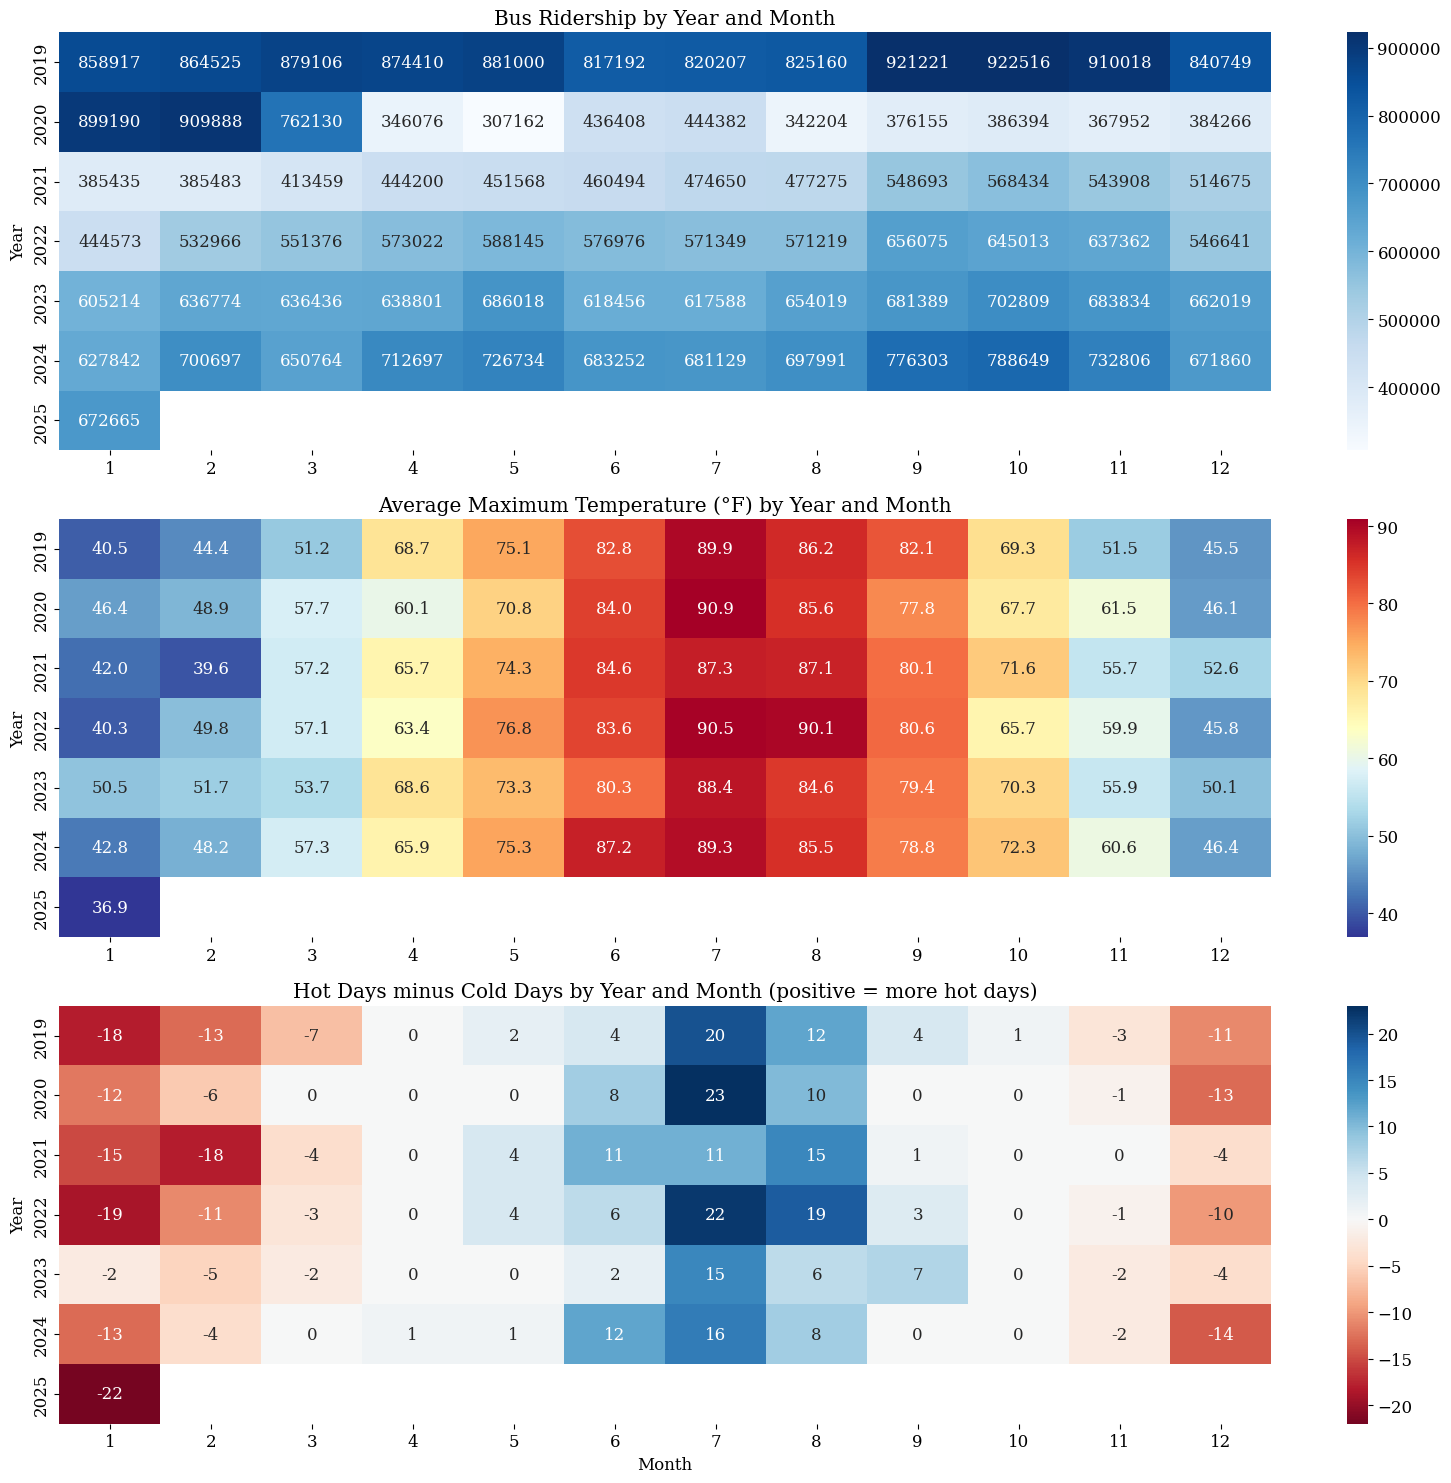

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more academic style for plots
# plt.style.use('seaborn-whitegrid')  # Use a clean, academic style # This line caused the error
#plt.style.use('seaborn-white')  # Use a clean, academic style # Changed to a similar style available by default
plt.rcParams['font.family'] = 'serif'  # Use serif font for a professional look
plt.rcParams['font.size'] = 12  # Base font size for better readability

# Load the datasets (assuming they are uploaded to Google Colab)
# If running in Google Colab, you can upload the files using:
# from google.colab import files
# uploaded = files.upload()
weather_data = pd.read_csv('3986077.csv')
ridership_data = pd.read_csv('Jan19_to_Present.csv')
socioeconomic_data = pd.read_csv('social_economic_data_rideship.csv')

# Display basic information about each dataset
print("Weather data shape:", weather_data.shape)
print("Ridership data shape:", ridership_data.shape)
print("Socioeconomic data shape:", socioeconomic_data.shape)

# Step 1: Preprocess the weather data
# Convert the date column to datetime format
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

# Check for missing values in key weather columns
print("\nMissing values in weather data:")
print(weather_data[['DATE', 'PRCP', 'TMAX', 'TMIN']].isnull().sum())

# Create year, month, and month name columns for merging
weather_data['Year'] = weather_data['DATE'].dt.year
weather_data['Month'] = weather_data['DATE'].dt.month
weather_data['Month_Name'] = weather_data['DATE'].dt.strftime('%B')

# Define extreme weather events with thresholds based on the entire dataset
def define_extreme_weather_events(df, hot_percentile=90, cold_percentile=10, precip_percentile=90):
    """
    Define extreme weather events based on percentile thresholds of the entire dataset.

    Parameters:
    -----------
    df : pandas.DataFrame
        Cleaned weather data with columns 'TMAX', 'TMIN', 'PRCP', 'DATE'
    hot_percentile : float
        Percentile threshold for defining extremely hot days (default: 90)
    cold_percentile : float
        Percentile threshold for defining extremely cold days (default: 10)
    precip_percentile : float
        Percentile threshold for defining heavy precipitation days (default: 90)

    Returns:
    --------
    pandas.DataFrame
        Weather data with added extreme event indicators
    dict
        Thresholds used for defining extreme events
    """
    # Create a copy to avoid modifying the original
    df_extremes = df.copy()

    # Calculate thresholds using the entire dataset
    # Extreme heat threshold (TMAX, 90th percentile)
    tmax_threshold = np.percentile(df_extremes['TMAX'], hot_percentile)
    df_extremes['VERY_HOT'] = (df_extremes['TMAX'] >= tmax_threshold).astype(int)

    # Extreme cold threshold (TMIN, 10th percentile)
    tmin_threshold = np.percentile(df_extremes['TMAX'], cold_percentile)
    df_extremes['VERY_COLD'] = (df_extremes['TMAX'] <= tmin_threshold).astype(int)

    # Heavy precipitation threshold (PRCP, 90th percentile, non-zero precipitation days)
    prcp_threshold = np.percentile(df_extremes.loc[df_extremes['PRCP'] > 0, 'PRCP'], precip_percentile)
    df_extremes['HEAVY_PRECIP'] = (df_extremes['PRCP'] >= prcp_threshold).astype(int)

    # Document the thresholds used
    thresholds = {
        'hot_threshold': tmax_threshold,
        'cold_threshold': tmin_threshold,
        'precipitation': prcp_threshold
    }

    print("\nExtreme Weather Thresholds (Entire Dataset):")
    print(f"Hot > {thresholds['hot_threshold']:.1f}°F")
    print(f"Cold < {thresholds['cold_threshold']:.1f}°F")
    print(f"Heavy Precipitation: > {thresholds['precipitation']:.2f} inches")

    # Identify consecutive extreme days
    df_extremes['CONSEC_HOT'] = ((df_extremes['VERY_HOT'] == 1) &
                                 (df_extremes['VERY_HOT'].shift(1) == 1)).astype(int)
    df_extremes['CONSEC_COLD'] = ((df_extremes['VERY_COLD'] == 1) &
                                  (df_extremes['VERY_COLD'].shift(1) == 1)).astype(int)
    df_extremes['CONSEC_PRECIP'] = ((df_extremes['HEAVY_PRECIP'] == 1) &
                                    (df_extremes['HEAVY_PRECIP'].shift(1) == 1)).astype(int)

    # Create single (isolated) extreme day indicators
    df_extremes['SINGLE_HOT'] = ((df_extremes['VERY_HOT'] == 1) &
                                 (df_extremes['CONSEC_HOT'] == 0)).astype(int)
    df_extremes['SINGLE_COLD'] = ((df_extremes['VERY_COLD'] == 1) &
                                  (df_extremes['CONSEC_COLD'] == 0)).astype(int)
    df_extremes['SINGLE_PRECIP'] = ((df_extremes['HEAVY_PRECIP'] == 1) &
                                    (df_extremes['CONSEC_PRECIP'] == 0)).astype(int)

    # Create heat wave and cold wave indicators (3+ consecutive days)
    df_extremes['HEATWAVE'] = 0
    df_extremes['COLDWAVE'] = 0

    # Find sequences of 3 or more consecutive hot/cold days
    hot_count = 0
    cold_count = 0

    for i in range(len(df_extremes)):
        if df_extremes.iloc[i]['VERY_HOT'] == 1:
            hot_count += 1
        else:
            hot_count = 0

        if df_extremes.iloc[i]['VERY_COLD'] == 1:
            cold_count += 1
        else:
            cold_count = 0

        if hot_count >= 3:
            df_extremes.iloc[i, df_extremes.columns.get_loc('HEATWAVE')] = 1

        if cold_count >= 3:
            df_extremes.iloc[i, df_extremes.columns.get_loc('COLDWAVE')] = 1

    # Count extreme days for reporting
    print("\nExtreme Weather Event Counts:")
    print(f"Very Hot Days: {df_extremes['VERY_HOT'].sum()}")
    print(f"Very Cold Days: {df_extremes['VERY_COLD'].sum()}")
    print(f"Heavy Precipitation Days: {df_extremes['HEAVY_PRECIP'].sum()}")
    print(f"Consecutive Hot Days: {df_extremes['CONSEC_HOT'].sum()}")
    print(f"Consecutive Cold Days: {df_extremes['CONSEC_COLD'].sum()}")
    print(f"Consecutive Precipitation Days: {df_extremes['CONSEC_PRECIP'].sum()}")
    print(f"Heat Wave Days (3+ consecutive): {df_extremes['HEATWAVE'].sum()}")
    print(f"Cold Wave Days (3+ consecutive): {df_extremes['COLDWAVE'].sum()}")

    return df_extremes, thresholds

# Apply extreme weather definition
weather_with_extremes, weather_thresholds = define_extreme_weather_events(weather_data, hot_percentile=90, cold_percentile=10, precip_percentile=90)

# Visualize extreme weather events with academic styling
fig = plt.figure(figsize=(15, 12))

# Plot temperature extremes
ax1 = plt.subplot(3, 1, 1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['TMAX'], 'b-', alpha=0.3, label='Max Temperature', linewidth=1)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['VERY_HOT']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['VERY_HOT']==1, 'TMAX'],
            color='red', marker='o', s=30, label='Very Hot Days (90th percentile)', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['HEATWAVE']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['HEATWAVE']==1, 'TMAX'],
            color='darkred', marker='*', s=60, label='Heat Wave (3+ days)', alpha=0.9)

plt.axhline(y=weather_thresholds['hot_threshold'], color='red', linestyle='--', alpha=0.5, label='Hot Threshold', linewidth=1)
plt.ylabel('Maximum Temperature (°F)', fontsize=12)
plt.title('Extreme Heat Events', fontsize=14, pad=10)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10, frameon=True, edgecolor='black')
plt.grid(True, which='both', alpha=0.3)
plt.minorticks_on()

# Plot cold extremes
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['TMIN'], 'g-', alpha=0.3, label='Min Temperature', linewidth=1)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['VERY_COLD']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['VERY_COLD']==1, 'TMIN'],
            color='blue', marker='o', s=30, label='Very Cold Days (10th percentile)', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['COLDWAVE']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['COLDWAVE']==1, 'TMIN'],
            color='darkblue', marker='*', s=60, label='Cold Wave (3+ days)', alpha=0.9)

plt.axhline(y=weather_thresholds['cold_threshold'], color='blue', linestyle='--', alpha=0.5, label='Cold Threshold', linewidth=1)
plt.ylabel('Minimum Temperature (°F)', fontsize=12)
plt.title('Extreme Cold Events', fontsize=14, pad=10)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10, frameon=True, edgecolor='black')
plt.grid(True, which='both', alpha=0.3)
plt.minorticks_on()

# Plot precipitation extremes
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(weather_with_extremes['DATE'], weather_with_extremes['PRCP'], 'k-', alpha=0.3, label='Precipitation', linewidth=1)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['HEAVY_PRECIP']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['HEAVY_PRECIP']==1, 'PRCP'],
            color='purple', marker='o', s=30, label='Heavy Precipitation (90th percentile)', alpha=0.7)
plt.scatter(weather_with_extremes.loc[weather_with_extremes['CONSEC_PRECIP']==1, 'DATE'],
            weather_with_extremes.loc[weather_with_extremes['CONSEC_PRECIP']==1, 'PRCP'],
            color='indigo', marker='*', s=60, label='Consecutive Heavy Precip', alpha=0.9)

plt.axhline(y=weather_thresholds['precipitation'], color='purple', linestyle='--', alpha=0.5, label='Precipitation Threshold', linewidth=1)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.title('Heavy Precipitation Events', fontsize=14, pad=10)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10, frameon=True, edgecolor='black')
plt.grid(True, which='both', alpha=0.3)
plt.minorticks_on()

# Adjust layout to prevent overlap with the legends
plt.tight_layout()
plt.suptitle('Extreme Weather Events in Philadelphia (2019-2025)', y=1.02, fontsize=16)
plt.subplots_adjust(right=0.85)  # Make space for the legends on the right
plt.show()

# Step 2: Aggregate weather data to monthly level for merging with ridership data
weather_monthly = weather_with_extremes.groupby([weather_with_extremes['Year'], weather_with_extremes['Month']]).agg({
    'VERY_HOT': 'sum',
    'VERY_COLD': 'sum',
    'HEAVY_PRECIP': 'sum',
    'TMAX': 'mean',
    'TMIN': 'mean'
}).reset_index()

# Rename columns to match the expected format for merging
weather_monthly.columns = ['Year', 'Month_y', 'Very_Hot_Days', 'Very_Cold_Days', 'Heavy_Precip_Days', 'Avg_TMAX', 'Avg_TMIN']

# Step 3: Preprocess the ridership data
# Ensure the Month column in ridership_data is consistent (capitalize the month names)
ridership_data['Month'] = ridership_data['Month'].str.capitalize()

# Aggregate ridership data by Year, Month, and Mode
ridership_monthly = ridership_data.groupby(['Year', 'Month', 'Mode']).agg({
    'Ridership': 'sum'
}).reset_index()

# Map month names to month numbers for merging
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
ridership_monthly['Month_y'] = ridership_monthly['Month'].map(month_map)

# Step 4: Merge the weather and ridership data
merged_data = ridership_monthly.merge(weather_monthly, on=['Year', 'Month_y'], how='left')

# Step 5: Visualize ridership trends and weather impacts
# Create a proper datetime index for easier time series plotting
merged_data['Date'] = pd.to_datetime(merged_data['Year'].astype(str) + '-' +
                                     merged_data['Month_y'].astype(str) + '-01')

# Sort the data chronologically
merged_data = merged_data.sort_values('Date')

# Plot ridership trends over time by mode
plt.figure(figsize=(16, 8))
for mode in merged_data['Mode'].unique():
    mode_data = merged_data[merged_data['Mode'] == mode]
    plt.plot(mode_data['Date'], mode_data['Ridership'], marker='o', label=mode)

plt.title('Monthly Ridership by Transit Mode Over Time')
plt.xlabel('Date')
plt.ylabel('Total Ridership')
plt.legend(title='Transit Mode')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a facet grid to show extreme weather impact by mode over time
g = sns.FacetGrid(merged_data, col="Mode", col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x="Date", y="Ridership")
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Total Ridership")
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()

# Create a heatmap showing ridership, temperature, and precipitation
# First, pivot the data by Year and Month for Bus mode
pivot_data = merged_data[merged_data['Mode'] == 'Bus'].pivot_table(
    index='Year',
    columns='Month_y',
    values=['Ridership', 'Avg_TMAX', 'Very_Hot_Days', 'Very_Cold_Days', 'Heavy_Precip_Days']
)

# Plot heatmaps
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

# Ridership heatmap
sns.heatmap(pivot_data['Ridership'], annot=True, fmt='.0f', cmap='Blues', ax=axes[0])
axes[0].set_title('Bus Ridership by Year and Month')
axes[0].set_ylabel('Year')
axes[0].set_xlabel('')

# Temperature heatmap
sns.heatmap(pivot_data['Avg_TMAX'], annot=True, fmt='.1f', cmap='RdYlBu_r', ax=axes[1])
axes[1].set_title('Average Maximum Temperature (°F) by Year and Month')
axes[1].set_ylabel('Year')
axes[1].set_xlabel('')

# Weather events heatmap - combine hot, cold, and precipitation days
weather_events = pivot_data['Very_Hot_Days'] - pivot_data['Very_Cold_Days']
sns.heatmap(weather_events, annot=True, fmt='.0f', cmap='RdBu', center=0, ax=axes[2])
axes[2].set_title('Hot Days minus Cold Days by Year and Month (positive = more hot days)')
axes[2].set_ylabel('Year')
axes[2].set_xlabel('Month')

plt.tight_layout()
plt.show()
